# 02. NN classification with PyTorch

Classificaation is a problem of predictimg if something is one thing or the other (there can be miltiple things).

## Make classification data and get it ready

In [ ]:
import sklearn
from sklearn.datasets import make_circles


In [ ]:
# Make 1000 samples
n_samples = 1000

# create circles
X, y = make_circles(n_samples,
                    noise= 0.03,
                    random_state=42)

In [ ]:
len(X), len(y)

(1000, 1000)

In [ ]:
print(f'First 5 samples of X: \n {X[:5]}')
print(f'First 5 samples of y: \n {y[:5]}')

First 5 samples of X: 
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: 
 [1 1 1 1 0]


In [ ]:
# make a df of circle data
import pandas as pd

circles = pd.DataFrame({'X1': X[:, 0],
                        'X2': X[:, 1],
                        'label': y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


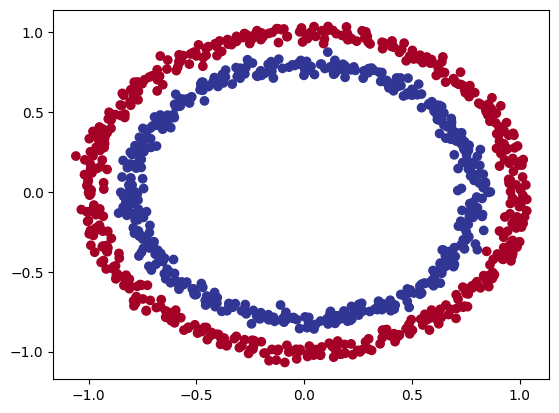

In [ ]:
# visualize
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

Note: The data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment but still sizable enought to practice the fundamentals.


### 1.1 Check input and output shapes

In [ ]:
X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
# view the first egs of features and labels
X_sample = X[0]
y_sample = y[0]

print(f'Values for one sample of X: {X_sample} and the same for y: {y_sample}')
print(f'Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}')

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train-test splits

In [ ]:
import torch

# turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [ ]:
# slit data to train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   random_state=42)

In [ ]:
len(X_train), len(X_test)

(800, 200)

## 2. Building a model

Build a model to classif blue and red dots.

To do so, we want to:
1. Setup device agnostic code so our code will run on an accelerator (GPU) if there is one
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop


In [ ]:
# imoport pytorch and nn
import torch
from torch import nn

# make device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

Now:
1. subclass `nn.Module`
2. Creat 2 `nn.Linear()` layersthat are capable of handling the shapes of our data
3. Define a `forward()` method that outlines the forward pass/computation
4. Instantiate an instance of our model class and send it to the tarer device

In [ ]:
# construct a model
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # create 2 layers
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5,
                                 out_features=1) # i.e the same shape as y

    def forward(self, x):
        return self.layer_2(self.layer_1(x)) #x ->layer_1 -> layer_2 ->output


model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
next(model_0.parameters()).device

device(type='cpu')

In [ ]:
# replicate above model with nn.Sequntial()

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1),
    nn.ReLU()
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
  (2): ReLU()
)

In [ ]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]])),
             ('0.bias', tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370])),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]])),
             ('1.bias', tensor([-0.1213]))])

In [ ]:
# make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f'Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}')
print(f'Length of test samples: {len(X_test)}, Shape: {X_test.shape}')
print(f'\nFirst 10 predictions: \n{untrained_preds[:10]}')
print(f'\nFirst 10 labels: \n{y_test[:10]}')

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions: 
tensor([[0.0000],
        [0.0000],
        [0.0894],
        [0.0000],
        [0.2967],
        [0.2968],
        [0.1405],
        [0.2178],
        [0.0805],
        [0.0000]])

First 10 labels: 
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

Which loss fucntion or optimizer should you use?

Regression -> MAE, MSE

Classification -> BCE, Categorical CE

In [ ]:
loss_funct =  nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)



In [ ]:
# calc accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

## 3. Train model

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**.

We can convert these **logits** into **prediction probabilities** by passing them to some kind of activation function (e.g sigmoid for binary classification and softmax for multiclass classification).

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the argmax().

In [ ]:
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]

y_logits

tensor([[0.0000],
        [0.0000],
        [0.0894],
        [0.0000],
        [0.2967]])

In [ ]:
# use sigmoid on logits then use bce to check the correctness of the probabiliythat sigmoid gave
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5000],
        [0.5000],
        [0.5223],
        [0.5000],
        [0.5736]])

In [ ]:
torch.round(y_pred_probs)

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.]])

For our prediction probabililty values, we need to perform a range-style rounding on them:

* `y_pred_probs` >= 0.5, `y = 1` (class 1)
* `y_pred_probs` < 0.5, `y = 0` (class 0)

In [ ]:
# find the predicted labels
y_preds = torch.round(y_pred_probs)

# in full (logits -> pred_probs  -> pred_labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# check the equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 1., 0., 1.])

### Building a training and test loop

In [ ]:
torch.manual_seed(42)
epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_0.train()
    logits = model_0(X_train).squeeze()
    pred_probs = torch.sigmoid(logits)
    predictions = torch.round(pred_probs)
    loss = loss_funct(logits, #expects raw logits as input but BCE exprects prediction probs as input
                      y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=predictions)

    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    # test
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred_probs = torch.sigmoid(test_logits)
        test_preds =torch.round(test_pred_probs)

        test_loss = loss_funct(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)

        if epoch % 10 == 0:
            print(f'Epoch: {epoch} | loss: {loss:.5f}, Acc: {acc:.2f} | test loss: {test_loss}, test acc: {test_acc:.2f}')


Epoch: 0 | loss: 0.70005, Acc: 51.88 | test loss: 0.6975817680358887, test acc: 58.00
Epoch: 10 | loss: 0.69728, Acc: 51.38 | test loss: 0.6956692337989807, test acc: 57.00
Epoch: 20 | loss: 0.69564, Acc: 52.25 | test loss: 0.6943101286888123, test acc: 58.00
Epoch: 30 | loss: 0.69409, Acc: 51.50 | test loss: 0.6927725076675415, test acc: 50.50
Epoch: 40 | loss: 0.69372, Acc: 50.12 | test loss: 0.692671537399292, test acc: 51.50
Epoch: 50 | loss: 0.69351, Acc: 50.00 | test loss: 0.6926791667938232, test acc: 51.50
Epoch: 60 | loss: 0.69339, Acc: 50.38 | test loss: 0.6927270293235779, test acc: 51.00
Epoch: 70 | loss: 0.69331, Acc: 50.00 | test loss: 0.692791759967804, test acc: 50.00
Epoch: 80 | loss: 0.69326, Acc: 50.00 | test loss: 0.692862868309021, test acc: 50.00
Epoch: 90 | loss: 0.69323, Acc: 50.25 | test loss: 0.6929311156272888, test acc: 50.00


## Make predictions and evaluate the model

From the metrics, it looks like our model isn't learninh anything...

So to inspect it, we will make some predictions and make them visual.

In order to do this, we will import a function called `plot_decision_boundary()` from https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

In [ ]:
import requests
from pathlib import Path
from google.colab import drive

# drive.mount('/content/drive')

# Download helper functions from the link if it is not already downloaded
if Path('helper_funtions.py').is_file():
    print('helper_funtions.py already exists, skipping download')
else:
    print('Downloading helper_funtions.py')
    r = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    with open('helper_funtions.py', 'wb') as f:
        f.write(r.content)

import sys
sys.path.append('pytorch')

from helper_funtions import plot_decision_boundary, plot_predictions

helper_funtions.py already exists, skipping download


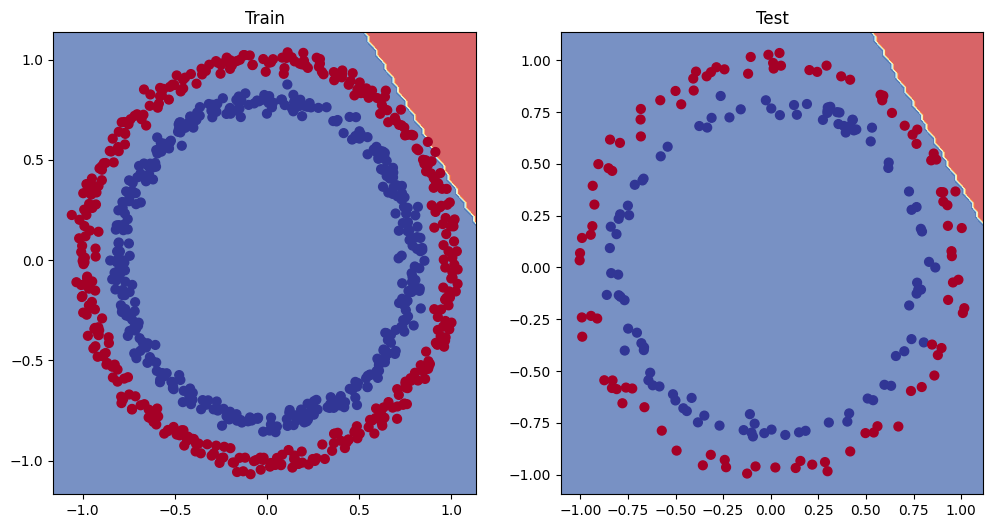

In [ ]:
# plot decision boundary of a model
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_0, X_test, y_test)


## 5. Improving a model (hyper parameter turning)
* Add more layers
* Add more hidden units e.g go from 5 to 10 neurons per hidden layer
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function


So let's try:
* Change hidden units from 5 -> 10
* Change number of layers from 2 -> 3
* Increase epochs from 100 -> 1000


In [ ]:
X_train[:5]

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        [-0.9666, -0.2256],
        [-0.1666,  0.7994]])

In [ ]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        # z = self.layer_1(x) # z is logits
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
torch.manual_seed(42)
epochs = 1000

optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

# X_train, y_train = X_train.to(device), y_train.to(device)
# X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_1.train()
    logits = model_1(X_train).squeeze()
    pred_probs = torch.sigmoid(logits)
    predictions = torch.round(pred_probs)
    loss = loss_funct(logits, #expects raw logits as input but BCE exprects prediction probs as input
                      y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=predictions)

    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    # test
    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred_probs = torch.sigmoid(test_logits)
        test_preds =torch.round(test_pred_probs)

        test_loss = loss_funct(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)

    if epoch % 100 == 0:
        print(f'Epoch: {epoch} | loss: {loss:.5f}, Acc: {acc:.2f} | test loss: {test_loss}, test acc: {test_acc:.2f}')


Epoch: 0 | loss: 0.69396, Acc: 50.88 | test loss: 0.6926146745681763, test acc: 51.00
Epoch: 100 | loss: 0.69305, Acc: 50.38 | test loss: 0.6937903761863708, test acc: 48.00
Epoch: 200 | loss: 0.69299, Acc: 51.12 | test loss: 0.6943727135658264, test acc: 46.00
Epoch: 300 | loss: 0.69298, Acc: 51.62 | test loss: 0.6945767998695374, test acc: 45.00
Epoch: 400 | loss: 0.69298, Acc: 51.12 | test loss: 0.6946452260017395, test acc: 46.00
Epoch: 500 | loss: 0.69298, Acc: 51.00 | test loss: 0.6946679949760437, test acc: 46.00
Epoch: 600 | loss: 0.69298, Acc: 51.00 | test loss: 0.694675624370575, test acc: 46.00
Epoch: 700 | loss: 0.69298, Acc: 51.00 | test loss: 0.6946781873703003, test acc: 46.00
Epoch: 800 | loss: 0.69298, Acc: 51.00 | test loss: 0.6946792006492615, test acc: 46.00
Epoch: 900 | loss: 0.69298, Acc: 51.00 | test loss: 0.694679319858551, test acc: 46.00


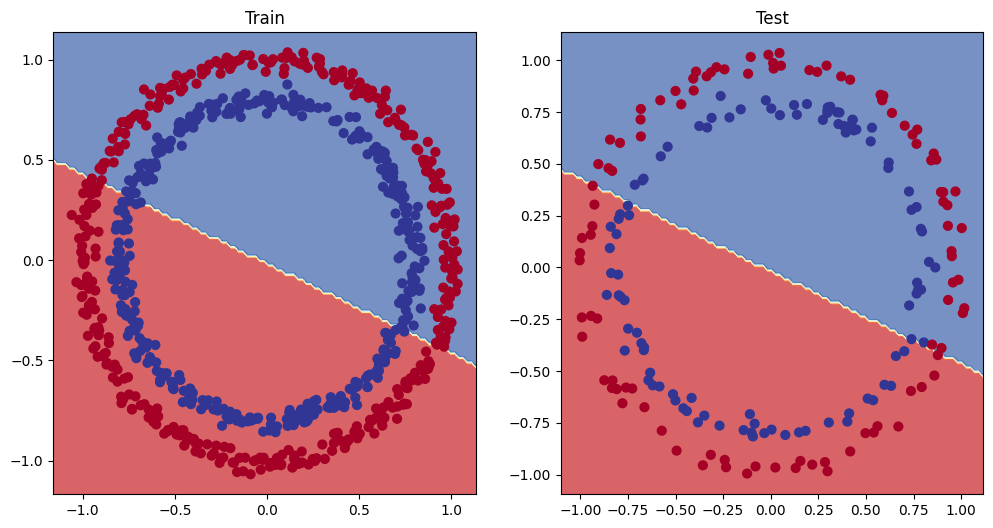

In [ ]:
# plot decision boundary of a model
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_1, X_test, y_test)


### 5.1 Preparing data to see if our model can fit a straight line
One way to troubleshoot a larger problem is to test out a smaller problem.

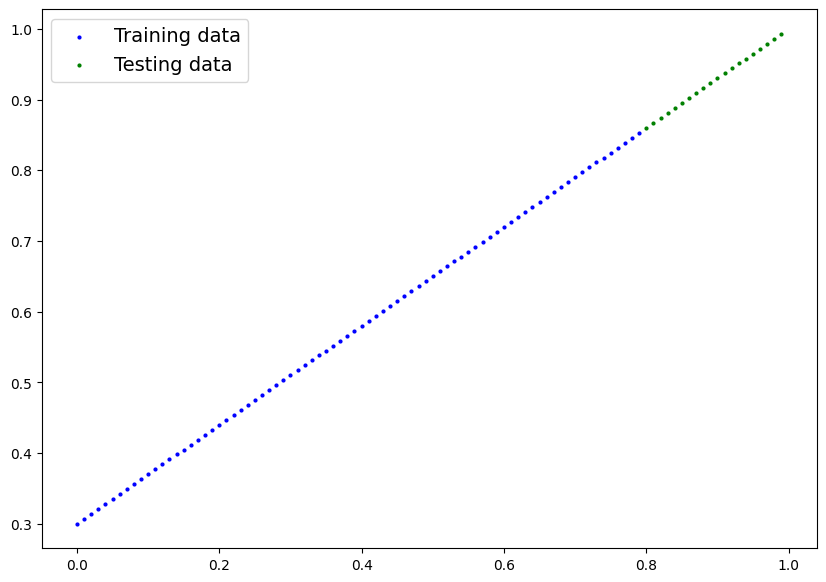

In [ ]:
# create data
weight = 0.7
bias = 0.3
X_reg = torch.arange(0, 1, 0.01).unsqueeze(dim=1)
y_reg = weight * X_reg + bias

X_train_reg, y_train_reg = X_reg[:80], y_reg[:80]
X_test_reg, y_test_reg = X_reg[80:], y_reg[80:]

plot_predictions(X_train_reg, y_train_reg, X_test_reg, y_test_reg)

### 5.2 Adjusting `model_1` to fit a straight line

In [ ]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)
model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.01)

In [ ]:
epochs = 100

X_train_reg, y_train_reg = X_train_reg.to(device), y_train_reg.to(device)
X_test_reg, y_test_reg = X_test_reg.to(device), y_test_reg.to(device)

for epoch in range(epochs):
    model_2.train()
    y_reg_pred = model_2(X_train_reg)

    reg_loss = loss_fn(y_reg_pred, y_train_reg)

    optimizer.zero_grad()

    reg_loss.backward()

    optimizer.step()

    # test
    model_2.eval()
    with torch.inference_mode():
        test_reg_pred = model_2(X_test_reg)
        test_reg_loss = loss_fn(test_reg_pred, y_test_reg)

    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Loss: {reg_loss:.5f} | Test Loss: {test_reg_loss}')


Epoch: 0 | Loss: 0.75986 | Test Loss: 0.9110288619995117
Epoch: 10 | Loss: 0.40240 | Test Loss: 0.5047394037246704
Epoch: 20 | Loss: 0.06007 | Test Loss: 0.10150804370641708
Epoch: 30 | Loss: 0.01559 | Test Loss: 0.03230736404657364
Epoch: 40 | Loss: 0.03092 | Test Loss: 0.0011067688465118408
Epoch: 50 | Loss: 0.03196 | Test Loss: 0.0010761826997622848
Epoch: 60 | Loss: 0.03192 | Test Loss: 0.0017018287908285856
Epoch: 70 | Loss: 0.03081 | Test Loss: 0.0009658097987994552
Epoch: 80 | Loss: 0.03077 | Test Loss: 0.0014975250232964754
Epoch: 90 | Loss: 0.02967 | Test Loss: 0.000923287880141288


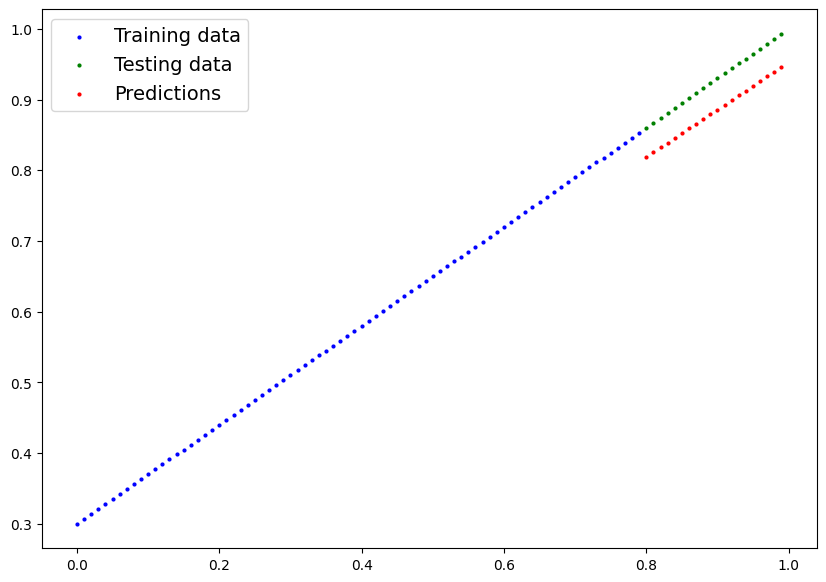

In [ ]:
with torch.inference_mode():
    new_y_pred = model_2(X_test_reg)

plot_predictions(X_train_reg, y_train_reg, X_test_reg, y_test_reg, predictions = new_y_pred)

## 6. The missing piece: non-linearity

"What patterns could you draw if you were given an infinite amount of straight and non-straight lines?"

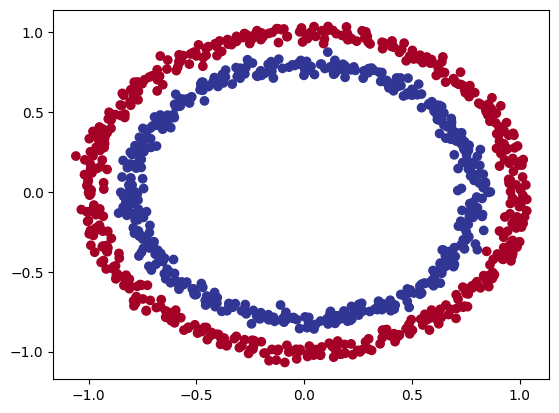

In [ ]:
# Make 1000 samples
n_samples = 1000

# create circles
X, y = make_circles(n_samples,
                    noise= 0.03,
                    random_state=42)

plt.scatter(x=X[:, 0],  y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [ ]:
# turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   random_state=42)

### 6.1 Building a model with non-linearity

In [ ]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()


    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

### 6.2 Training non-linear model

In [ ]:
torch.manual_seed(42)
epochs = 1000

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params= model_3.parameters(), lr=0.1)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_3.train()
    logits = model_3(X_train).squeeze()
    pred_probs = torch.sigmoid(logits)
    predictions = torch.round(pred_probs)
    loss = loss_fn(logits, #expects raw logits as input but BCE exprects prediction probs as input
                      y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=predictions)

    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    # test
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred_probs = torch.sigmoid(test_logits)
        test_preds =torch.round(test_pred_probs)

        test_loss = loss_funct(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)

    if epoch % 100 == 0:
        print(f'Epoch: {epoch} | loss: {loss:.5f}, Acc: {acc:.2f} | test loss: {test_loss}, test acc: {test_acc:.2f}')


Epoch: 0 | loss: 0.69541, Acc: 50.00 | test loss: 0.6958402395248413, test acc: 50.00
Epoch: 100 | loss: 0.69015, Acc: 53.12 | test loss: 0.6906030178070068, test acc: 50.00
Epoch: 200 | loss: 0.68791, Acc: 54.25 | test loss: 0.6876158714294434, test acc: 54.50
Epoch: 300 | loss: 0.68421, Acc: 58.88 | test loss: 0.6834312677383423, test acc: 59.00
Epoch: 400 | loss: 0.67898, Acc: 62.25 | test loss: 0.6783328056335449, test acc: 64.50
Epoch: 500 | loss: 0.67115, Acc: 64.00 | test loss: 0.6711984276771545, test acc: 67.50
Epoch: 600 | loss: 0.65742, Acc: 72.00 | test loss: 0.6593638062477112, test acc: 69.50
Epoch: 700 | loss: 0.63149, Acc: 85.12 | test loss: 0.637440025806427, test acc: 84.00
Epoch: 800 | loss: 0.58168, Acc: 91.88 | test loss: 0.5947702527046204, test acc: 91.50
Epoch: 900 | loss: 0.49246, Acc: 93.88 | test loss: 0.5176013708114624, test acc: 93.50


### 6.3 Predicting non-linear model

In [ ]:
# make predictions
model_3.eval()
with torch.inference_mode():
    test_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

test_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

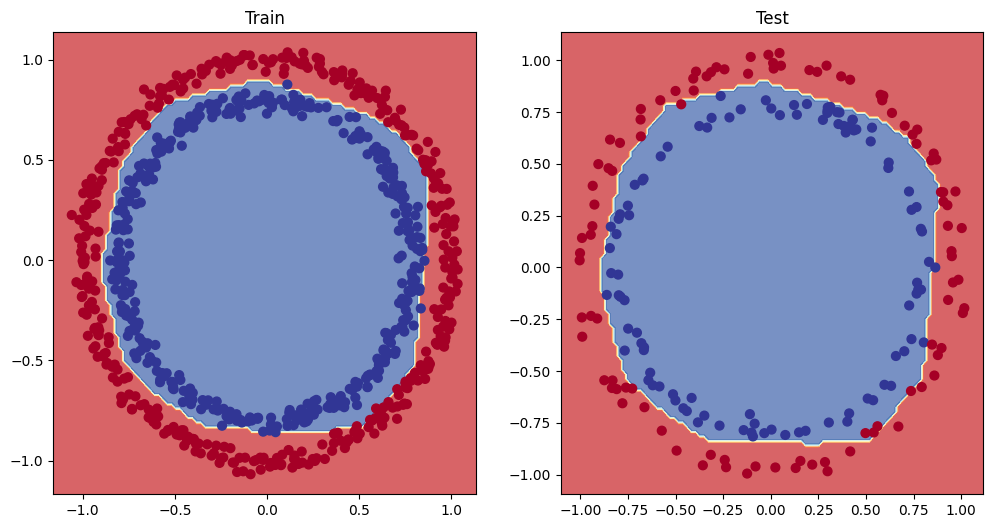

In [ ]:
# plot decision boundary of a model
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_3, X_train, y_train)

plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_3, X_test, y_test)

## 7. Replicating non-linear activation functions

Recall that in NNs, instead of telling the model what to learn, we give it the tools to discover patterns in the data and patterns on its own.

These tools are linear and non-linear functions.

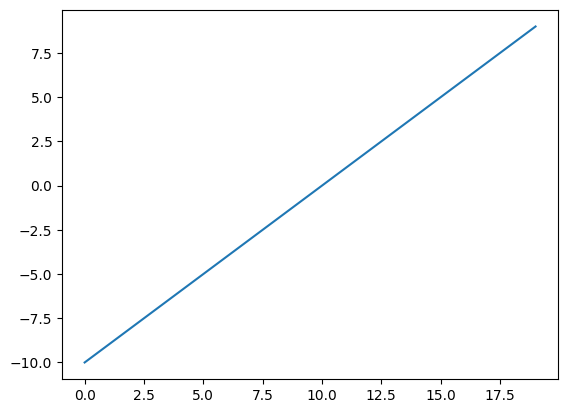

In [ ]:
# creaate a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
plt.plot(A)

#### ReLU

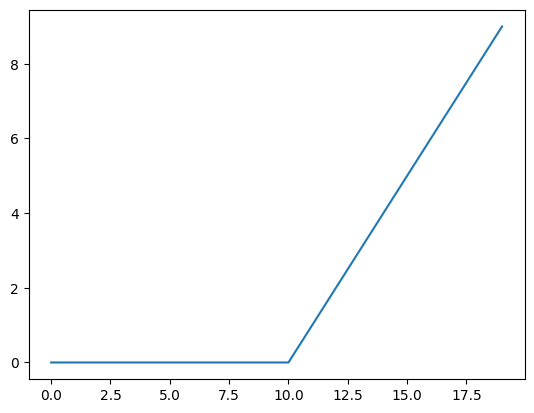

In [ ]:
plt.plot(torch.relu(A))

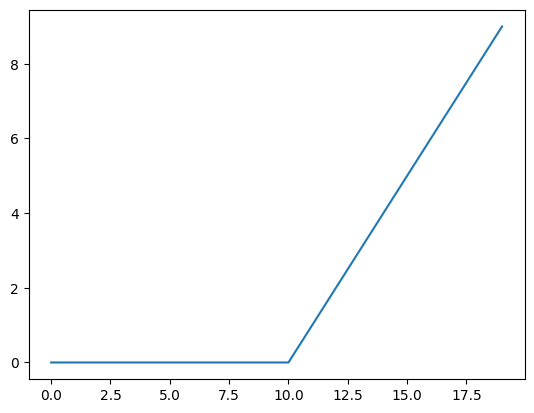

In [ ]:
def relu(x:torch.tensor) -> torch.tensor:
    return torch.maximum(torch.tensor(0), x)

plt.plot(relu(A))

#### Sigmoid

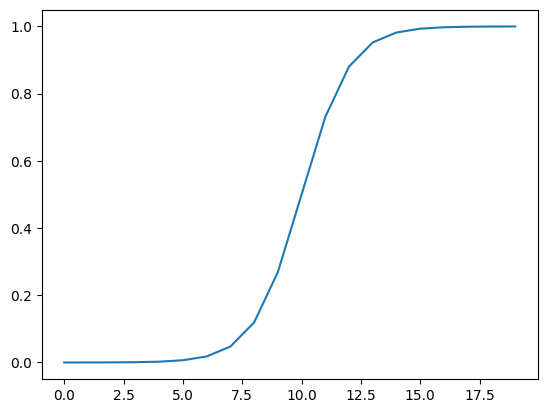

In [ ]:
plt.plot(torch.sigmoid(A))

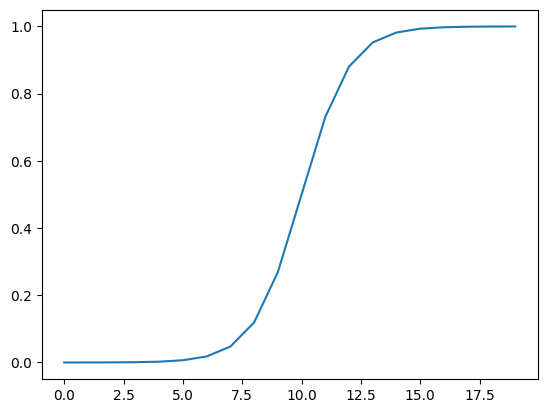

In [ ]:
def sigmoid(x:torch.tensor) -> torch.tensor:
    return 1 / (1 + torch.exp(-x))

plt.plot(sigmoid(A))

## 8. Putting it all together with a multi-class classification problem

### 8.1 Creating a toy dataset

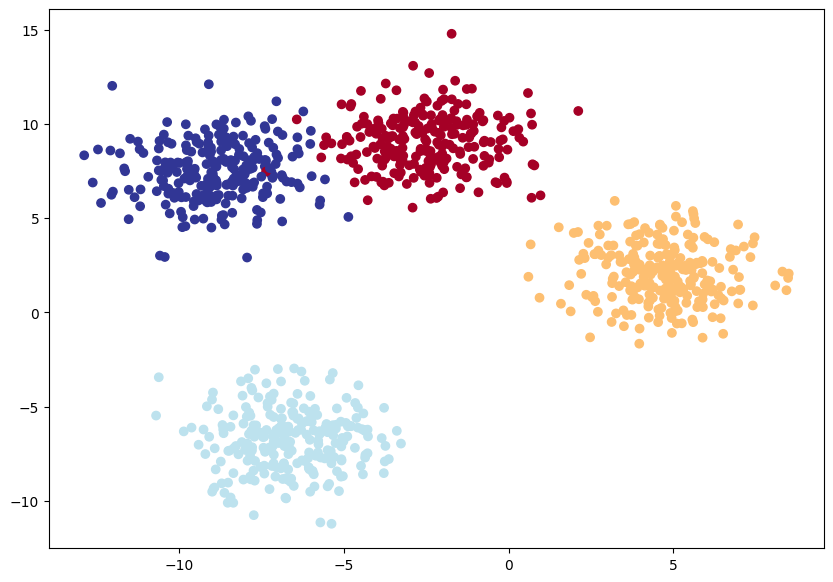

In [ ]:
import torch
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# create multiclass data
X_blob, y_blob = make_blobs(n_samples=1000, n_features=NUM_FEATURES,
                            centers=NUM_CLASSES, cluster_std=1.5, # the higher it is, the more clusters mix up/are layered on each other
                            random_state=RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

### 8.2 Building a multiclass classification model

In [ ]:
# device anostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """
        Initializes muticalss classification model.
        Args:
            input_features (int): Number of input features to the model(columns in data)
            output_features (int): Number of ouput features to the model(number of classification classes)
            hidden_units (int): Number of hidden units/neurons between layers
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features))

    def forward(self, x):
        return self.linear_layer_stack(x)

model_4 = BlobModel(input_features=NUM_FEATURES, output_features=NUM_CLASSES,
                    ).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Getting prediction probabilities for a multi-class PyTorch model

Logits (raw output of the model) -> Pred probs(use `torch.softmax`) -> Pred labels (take argmax of the prediction probabilities)

In [ ]:
model_4.eval()

with torch.inference_mode():
    y_logits = model_4(X_blob_test.to(device))

y_logits[:10]


tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]])

In [ ]:
y_blob_test[:10]

tensor([1., 3., 2., 1., 0., 3., 2., 0., 2., 0.])

In [ ]:
# Convert our model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]])
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]])


In [ ]:
# Convert our model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1])

In [ ]:
y_blob_test

tensor([1., 3., 2., 1., 0., 3., 2., 0., 2., 0., 0., 1., 0., 0., 0., 3., 3., 2.,
        3., 3., 3., 0., 1., 2., 2., 2., 3., 0., 1., 0., 3., 1., 1., 3., 1., 2.,
        1., 3., 0., 2., 0., 3., 3., 2., 0., 3., 1., 1., 0., 3., 1., 0., 1., 1.,
        3., 2., 1., 1., 3., 2., 2., 0., 3., 2., 2., 0., 0., 3., 3., 0., 0., 3.,
        3., 3., 2., 3., 3., 3., 3., 1., 0., 2., 3., 2., 3., 3., 2., 3., 3., 2.,
        3., 3., 1., 3., 3., 3., 1., 0., 3., 2., 0., 0., 3., 0., 2., 3., 1., 0.,
        3., 2., 1., 1., 0., 2., 2., 3., 0., 0., 1., 2., 2., 3., 0., 1., 2., 0.,
        0., 0., 2., 3., 1., 2., 3., 2., 0., 3., 0., 0., 1., 1., 1., 0., 2., 2.,
        2., 2., 0., 3., 3., 2., 2., 1., 3., 2., 0., 0., 3., 3., 2., 1., 2., 0.,
        3., 2., 0., 3., 2., 0., 2., 2., 2., 0., 3., 1., 1., 1., 1., 1., 3., 1.,
        0., 2., 2., 1., 2., 2., 0., 1., 2., 2., 0., 0., 1., 3., 2., 0., 3., 1.,
        2., 1.])

In [ ]:
model_4.state_dict()

OrderedDict([('linear_layer_stack.0.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998]])),
             ('linear_layer_stack.0.bias',
              tensor([ 0.5451,  0.1045, -0.3301,  0.1802, -0.3258, -0.0829, -0.2872,  0.4691])),
             ('linear_layer_stack.2.weight',
              tensor([[-0.2791, -0.1630, -0.0998, -0.2126,  0.0334, -0.3492,  0.3193, -0.3003],
                      [ 0.2730,  0.0588, -0.1148,  0.2185,  0.0551,  0.2857,  0.0387, -0.1115],
                      [ 0.0950, -0.0959,  0.1488,  0.3157,  0.2044, -0.1546,  0.2041,  0.0633],
                      [ 0.1795, -0.2155, -0.3500, -0.1366, -0.2712,  0.2901,  0.1018,  0.1464],
                      [ 0.1118, -0.0062,  0.276

In [ ]:
list(model_4.parameters())

[Parameter containing:
 tensor([[ 0.5406,  0.5869],
         [-0.1657,  0.6496],
         [-0.1549,  0.1427],
         [-0.3443,  0.4153],
         [ 0.6233, -0.5188],
         [ 0.6146,  0.1323],
         [ 0.5224,  0.0958],
         [ 0.3410, -0.0998]], requires_grad=True),
 Parameter containing:
 tensor([ 0.5451,  0.1045, -0.3301,  0.1802, -0.3258, -0.0829, -0.2872,  0.4691],
        requires_grad=True),
 Parameter containing:
 tensor([[-0.2791, -0.1630, -0.0998, -0.2126,  0.0334, -0.3492,  0.3193, -0.3003],
         [ 0.2730,  0.0588, -0.1148,  0.2185,  0.0551,  0.2857,  0.0387, -0.1115],
         [ 0.0950, -0.0959,  0.1488,  0.3157,  0.2044, -0.1546,  0.2041,  0.0633],
         [ 0.1795, -0.2155, -0.3500, -0.1366, -0.2712,  0.2901,  0.1018,  0.1464],
         [ 0.1118, -0.0062,  0.2767, -0.2512,  0.0223, -0.2413,  0.1090, -0.1218],
         [ 0.1083, -0.0737,  0.2932, -0.2096, -0.2109, -0.2109,  0.3180,  0.1178],
         [ 0.3402, -0.2918, -0.3507, -0.2766, -0.2378,  0.1432,  0.1

### 8.4 Building a training loop

In [ ]:
loss_fn = nn.CrossEntropyLoss() # nn.NLLLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.1)

In [ ]:
# import torch.nn.functional as F
torch.manual_seed(42)

epochs= 1000

X_blob_train, X_blob_test, y_blob_train, y_blob_test = X_blob_train.to(device), X_blob_test.to(device), y_blob_train.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    model_4.train()

    y_logits = model_4(X_blob_train)
    # use softmax since it is multiclass classification insead of sigmoid
    # find the highest- probability in pred probs
    y_blob_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1).float()

    calc_loss = loss_fn(y_logits, y_blob_train.long())
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_blob_pred)

    optimizer.zero_grad()

    # calc_loss.requires_grad = True
    calc_loss.backward()
    optimizer.step()

    # test
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test).squeeze()
        test_y_pred = torch.argmax(torch.softmax(test_logits, dim=1), dim=1).float()

        test_loss = loss_fn(test_logits, y_blob_test.long())
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_y_pred)

    if epoch % 100 == 0:
        print(f'Epoch: {epoch} | loss: {loss:.5f}, Acc: {acc:.2f} | test loss: {test_loss}, test acc: {test_acc:.2f}')




Epoch: 0 | loss: 0.35364, Acc: 40.38 | test loss: 1.0755422115325928, test acc: 48.00
Epoch: 100 | loss: 0.35364, Acc: 99.25 | test loss: 0.024326978251338005, test acc: 99.50
Epoch: 200 | loss: 0.35364, Acc: 99.25 | test loss: 0.01651209406554699, test acc: 99.50
Epoch: 300 | loss: 0.35364, Acc: 99.25 | test loss: 0.01439980510622263, test acc: 99.50
Epoch: 400 | loss: 0.35364, Acc: 99.25 | test loss: 0.013353499583899975, test acc: 99.50
Epoch: 500 | loss: 0.35364, Acc: 99.25 | test loss: 0.012686330825090408, test acc: 99.50
Epoch: 600 | loss: 0.35364, Acc: 99.25 | test loss: 0.012183870188891888, test acc: 99.50
Epoch: 700 | loss: 0.35364, Acc: 99.25 | test loss: 0.011793375946581364, test acc: 99.50
Epoch: 800 | loss: 0.35364, Acc: 99.25 | test loss: 0.011468163691461086, test acc: 99.50
Epoch: 900 | loss: 0.35364, Acc: 99.25 | test loss: 0.011195656843483448, test acc: 99.50


### 8.6 Making and evaluating predictions with a PyTorch multi-class model

In [ ]:
# make predictions
model_4.eval()
with torch.inference_mode():
    test_preds = torch.argmax(torch.softmax(model_4(X_blob_test), dim=1), dim=1).float()
    # torch.round(torch.sigmoid()).squeeze()

test_preds[:10], y_blob_test[:10]

(tensor([1., 3., 2., 1., 0., 3., 2., 0., 2., 0.]),
 tensor([1., 3., 2., 1., 0., 3., 2., 0., 2., 0.]))

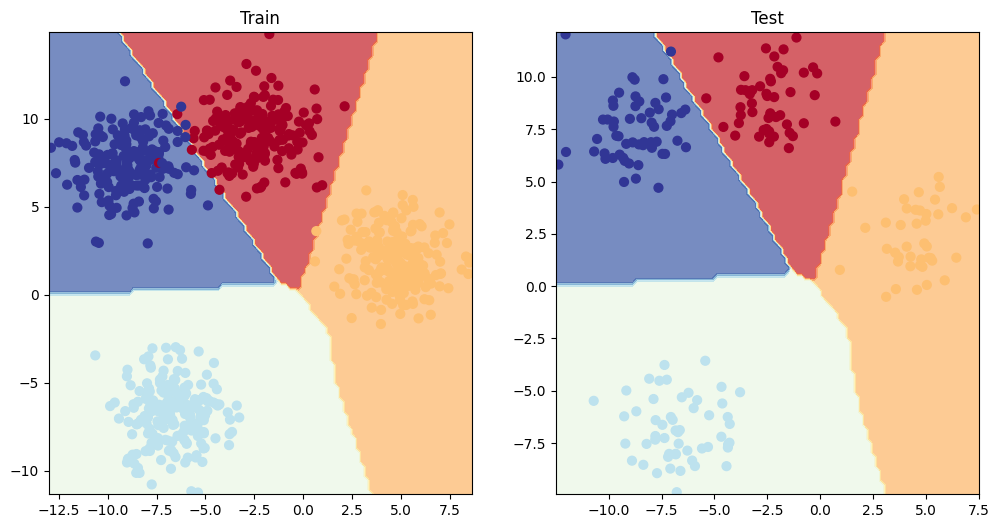

In [ ]:
# plot decision boundary of a model
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_4, X_blob_train, y_blob_train)

plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. A few more classification metrics(to evaluate our classification model)

* Accuracy (better for balanced classes)
* Precision
* Recall
* F1-score
* Confusion matrix
* Classification report


In [ ]:
%pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 5.0 MB/s eta 0:00:00


In [ ]:
from torchmetrics import Accuracy

# set up metric
torchmetric_acc = Accuracy(task="multiclass", num_classes=4).to(device)
torchmetric_acc(test_preds, y_blob_test)

tensor(0.9950)

# Exercises
https://colab.research.google.com/drive/1cqGwqI-2hWFbqI5IB_Vkhb6n_hWV_5nZ?hl=en#scrollTo=CSrUPgapO0tf